<a href="https://colab.research.google.com/github/dyjdlopez/fund_opts_python/blob/main/metaheuristics/metaopts_01_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1.3: Mixed Integer Linear Programming
$_\text{Metahuristics and Optimization | D.J.D. Lopez | 2026}$

Mixed-Integer Linear Programming (MILP) is a powerful optimization framework for modeling decision-making problems that involve both continuous and discrete choices. In a MILP, the objective function and all constraints are linear, but some decision variables are constrained to take integer (often binary) values.

Formally, a generic MILP can be written as
$$
\begin{aligned}
\min_{x} \;& c^\top x \\
\text{s.t. } & A x \le b, \\
            & x_i \in \mathbb{Z} \text{ for } i \in \mathcal{I}, \\
            & x_j \in \mathbb{R} \text{ for } j \notin \mathcal{I},
\end{aligned}
$$
where $c$ is the cost vector, $A$ is the constraint matrix, $b$ is the right-hand side vector, and $\mathcal{I}$ indexes the variables that must be integer-valued.

A particularly important special case is that of binary (0-1) variables, where
$$
x_i \in \{0,1\},
$$
which are used to encode yes/no decisions such as opening a facility, assigning a task, or choosing a route. By combining continuous variables (for flows, quantities, or capacities) with integer or binary variables (for logical and structural decisions), MILP models can represent a wide range of real-world planning, scheduling, and design problems.


## 1. Integer Programming

Integer Programming (IP) is a class of optimization problems in which some or all decision variables are restricted to take integer values. This makes IP suitable for modeling situations where the underlying decisions are inherently discrete, such as numbers of machines, vehicles, or tasks, and where fractional solutions would be meaningless.

A standard **integer linear program** (ILP) can be written as
$$
\begin{aligned}
\min_{x} \;\; & c^\top x \\
\text{s.t.} \;\; & A x \le b, \\
                 & x \in \mathbb{Z}^n,
\end{aligned}
$$
where $c \in \mathbb{R}^n$, $A \in \mathbb{R}^{m \times n}$, $b \in \mathbb{R}^m$, and the integrality constraint $x \in \mathbb{Z}^n$ enforces that every component of $x$ is an integer.

In many applications, it is useful to distinguish between **general** integer variables and **binary** variables. A binary variable is constrained to take values in $\{0,1\}$:
$$
x_i \in \{0,1\},
$$
and is typically used to represent yes/no or on/off decisions (for example, whether to open a facility, select an option, or activate a constraint). General integer variables may take any integer value within given bounds, for instance
$$
\ell_i \le x_i \le u_i, \qquad x_i \in \mathbb{Z},
$$
which is natural when counting items, people, or time periods.

From a computational point of view, integer programming problems are significantly harder than their linear programming relaxations, because the feasible set is discrete and generally nonconvex. Nevertheless, modern solvers can handle large practical instances using techniques such as branch-and-bound, cutting planes, and branch-and-cut, making integer programming a central tool in operations research, logistics, scheduling, and many other applications.

### Example: Knapsack Problem

Consider a 0-1 knapsack problem. We have $n$ items, and each item $i \in \{1,\dots,n\}$ has a value $v_i > 0$ and a weight $w_i > 0$. We also have a knapsack with capacity $W > 0$. The goal is to choose a subset of items whose total weight does not exceed $W$, while maximizing the total value.

We introduce binary decision variables
$$
x_i =
\begin{cases}
1, & \text{if item } i \text{ is included in the knapsack}, \\
0, & \text{otherwise},
\end{cases}
$$
$$
i = 1,\dots,n.
$$

The 0--1 knapsack problem can then be formulated as the integer linear program
$$
\begin{aligned}
\max_{x} \;\; & \sum_{i=1}^n v_i x_i \\
\text{s.t.} \;\; & \sum_{i=1}^n w_i x_i \leq W, \\
                 & x_i \in \{0,1\}, \quad i = 1,\dots,n.
\end{aligned}
$$

Here, the objective function $\sum_{i=1}^n v_i x_i$ represents the total value of the selected items. The capacity constraint $\sum_{i=1}^n w_i x_i \leq W$ ensures that the total weight of the chosen items does not exceed the knapsack capacity, and the integrality constraints $x_i \in \{0,1\}$ enforce that each item is either taken in whole or not taken at all.


### 1.1 Parameters

In an ILP model, the first step is to translate the verbal problem into numerical data. Here, each item $i$ has a value $v$ and a weight $w$, stored in the vectors values and weights. The scalar $W$ is the knapsack capacity, which defines a hard resource limit that our solution must respect. The dimension n determines how many decision variables we will have in the optimization model.

In [8]:
import cvxpy as cp
import numpy as np

n = 5 # Number of items
objects = ['cakes','carrots','watermelon','pineapple','apple']
values = np.array([10, 7, 25, 15, 6]) # Values ($) of each item
weights = np.array([2, 3, 6, 4, 1]) # Weights (kg) of each item
W = 10 # Knapsack capacity (kg)

### 1.2 Decision Variables

Decision variables encode the choices the optimization model can make. For the 0-1 knapsack problem, each decision is “take item $i$ or not,” which is naturally represented by a binary variable $x_i \in {0,1} $. In CVXPY, setting `boolean=True` enforces this integrality constraint. The vector x therefore represents the subset of items chosen by the ILP.

In [3]:
x = cp.Variable(n, boolean=True)

### 1.3 Constraints

Constraints describe the feasible set of solutions. The key constraint in knapsack is the capacity limit, $\sum_i w_ix_i \leq W$, which forbids any selection of items whose total weight exceeds the knapsack capacity. In CVXPY, this is expressed as `weights @ x <= W`. Additional constraints can be added in the same way, for example enforcing a minimum number of selected items, or forbidding certain combinations.

In [4]:
constraints = []

constraints.append(weights @ x <= W)

# constraints.append(cp.sum(x) >= 1) ## ensure at least one item is chosen

### 1.4 Objective Function

The objective captures what we are trying to optimize. For knapsack, the goal is to maximize the total value of selected items, $\sum_i v_i x_i$. In vector notation, this is simply the inner product $v^⊤x$, implemented as `values @ x` in Python. Declaring `cp.Maximize(...)` tells the solver to search over all feasible integer assignments for $x$ and pick the one with maximum total value.

In [5]:
objective = cp.Maximize(values @ x)

### 1.5 Running the Optimization

Once the objective and constraints are defined, they are combined into an optimization problem object. The call `prob.solve(...)` sends this ILP to a mixed-integer solver, which applies branch-and-bound and related techniques to search the discrete feasible space. Specifying a MILP-capable solver (such as `GLPK_MI`) is essential because the presence of boolean variables makes this a mixed-integer problem rather than a purely continuous LP.



In [6]:
prob = cp.Problem(objective, constraints)

prob.solve(solver=cp.GLPK_MI)

np.float64(41.0)

In [15]:
print("Status: ", prob.status)

chosen_items = [i for i in range(n) if x.value[i] > 0.5]
print("Chosen item indices: ", [objects[item] for item in chosen_items])
print("Total weight: ", weights[chosen_items].sum(), 'kg')
print("Total value: $", values[chosen_items].sum())

Status:  optimal
Chosen item indices:  ['cakes', 'watermelon', 'apple']
Total weight:  9 kg
Total value: $ 41


## 2. Mixed Integer Linear Programming

Integer linear programming (ILP) requires **all** decision variables to take integer values, often binary for yes/no choices. Mixed-integer linear programming (MILP) extends this by allowing some variables to be continuous and others integer, so it can model both discrete decisions (e.g., open/close, select/not select) and continuous quantities (e.g., flows, production levels) within one linear optimization framework. In this sense, ILP is a special case of MILP where no continuous variables are present.



## Example 1: Job Assignment

Suppose there are two workers and three jobs. Each worker has a limited number of hours they can work, and each job requires a certain number of hours to be completed. Our task is to decide which worker is assigned to which job, and how many hours they work on that job.

Let $\mathcal{W} = \{1,2\}$ be the set of workers and $\mathcal{J} = \{1,2,3\}$ be the set of jobs. For each worker $w$, let $h_w$ denote the maximum number of hours they can work. For each job $j$, let $r_j$ denote the total number of hours required by that job.

We introduce two types of decision variables. First, for each worker–job pair $(w,j)$ we define a continuous variable $x_{w j} \ge 0$ representing the number of hours worker $w$ spends on job $j$. Second, we introduce a binary variable $y_{w j} \in \{0,1\}$ which indicates whether worker $w$ is actually assigned to job $j$. In this way, the $x_{w j}$ capture the continuous allocation of hours, while the $y_{w j}$ capture the discrete assignment decisions.

As an objective, we can, for example, try to keep the schedule simple by minimizing the total number of assignments. This leads to the objective
$$
\min_{x,y} \; \sum_{w \in \mathcal{W}} \sum_{j \in \mathcal{J}} y_{w j},
$$
which penalizes every worker–job pair that is active. The constraints then ensure feasibility. Each job must receive exactly its required number of hours,
$$
\sum_{w \in \mathcal{W}} x_{w j} = r_j \quad \forall j \in \mathcal{J},
$$
and each worker must respect their available time,
$$
\sum_{j \in \mathcal{J}} x_{w j} \le h_w \quad \forall w \in \mathcal{W}.
$$
Finally, we link the continuous and binary variables using a simple big-$M$ constraint. Read more about [Big-M Method](https://medium.com/@talharehman.mtrkt/using-the-big-m-method-in-optimization-problems-ae38b5f98c58).
$$
0 \le x_{w j} \le M \, y_{w j} \quad \forall w \in \mathcal{W}, \; j \in \mathcal{J},
$$
where $M$ is a sufficiently large constant (for example, an upper bound on the number of hours any single worker could spend on one job). If $y_{w j} = 0$, then this inequality forces $x_{w j} = 0$, meaning worker $w$ cannot work on job $j$. If $y_{w j} = 1$, the model is free to assign a positive number of hours to that pair, up to the limit $M$.


In [16]:
## Parameters
workers = ['Arthur', 'Bessy']
jobs = ['Literature Review','Experiment','Manuscript Writing']

num_workers = len(workers)
num_jobs = len(jobs)

h = np.array([8.0, 6.0])  # Maximum hours each worker can work
r = np.array([3.0, 5.0, 4.0]) # Required hours for each job

M = 50 #Big-M

## Decision Variables
x = cp.Variable((num_workers, num_jobs), nonneg=True)
y = cp.Variable((num_workers, num_jobs), boolean=True)

In [20]:
constraints = []

for j in range(num_jobs):
    constraints.append(cp.sum(x[:, j]) == r[j])

for w in range(num_workers):
    constraints.append(cp.sum(x[w, :]) <= h[w])

for w in range(num_workers):
    for j in range(num_jobs):
        constraints.append(x[w, j] <= M * y[w, j])

## Objective function
objective = cp.Minimize(cp.sum(y))

problem = cp.Problem(objective, constraints)

In [21]:
solution_value = problem.solve(solver=cp.GLPK_MI)

print("Problem status:", problem.status)
print("Optimal objective value (min total assignments):", solution_value)

Problem status: optimal
Optimal objective value (min total assignments): 3.0


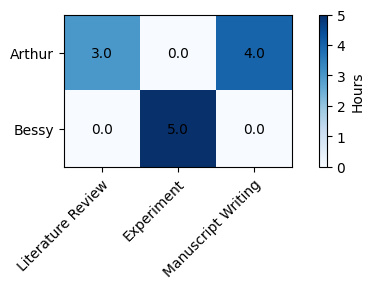

In [28]:
import matplotlib.pyplot as plt

x_sol = np.array(x.value)
y_sol = np.array(y.value)

fig, ax = plt.subplots(figsize=(6, 3))

im = ax.imshow(x_sol, cmap="Blues")

ax.set_xticks(range(num_jobs))
ax.set_yticks(range(num_workers))
ax.set_xticklabels(jobs)
ax.set_yticklabels(workers)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for w_idx in range(num_workers):
    for j_idx in range(num_jobs):
        hours = x_sol[w_idx, j_idx]
        assigned = y_sol[w_idx, j_idx] > 0.5
        text = f"{hours:.1f}" if hours > 1e-3 else "0.0"
        ax.text(j_idx, w_idx, text, ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


## Example 2: Crop Assignment
We consider a farmer who manages a square field divided into 16 patches arranged in a $4 \times 4$ grid. Let the set of patches be
$$
\mathcal{P} = \{1,2,\dots,16\},
$$
and the set of crops be
$$
\mathcal{C} = \{\text{Squash}, \text{Turnip}, \text{Radish}\}.
$$
Each patch $p \in \mathcal{P}$ has a fixed area (e.g., one unit of land), and the farmer can allocate an \emph{integer number of planting units} of each vegetable to that patch (for example, rows or beds). For each patch $p$ and crop $c$, we are given an expected yield per planting unit $y_{p c}$ (e.g., kilograms per row) and for each crop $c$ a profit per unit yield $\pi_c$ (e.g., \$/kg). The goal is to decide how many planting units of each vegetable to assign to each patch in order to maximize the total expected profit, subject to a simple capacity limit per patch.

### 2.1 Decision Variables

For each patch $p \in \mathcal{P}$ and crop $c \in \mathcal{C}$ we define an \emph{integer} decision variable
$$
x_{p c} \in \mathbb{Z}_{+},
$$
representing the number of planting units of crop $c$ on patch $p$ (for example, the number of rows of that vegetable in that patch).


In [120]:
## Parameters
patches = [(i, j) for i in range(4) for j in range(4)]  # 4x4 grid
num_patches = len(patches)

crops = ["Squash", "Turnip", "Radish"]
num_crops = len(crops)

patch_indices = range(num_patches)
crop_indices = range(num_crops)

# Profit per unit yield for each crop
cost = np.array([0.7, 0.12, 0.26])  # [Squash, Turnip, Radish]
price = np.array([4.0, 2.0, 3.0])

# Random expected yield per planting unit for each patch–crop pair
rng = np.random.default_rng(seed=0)  # fixed seed for reproducibility
y = rng.uniform(low=0.5, high=2.0, size=(num_patches, num_crops))

# Patch capacity
K = (1,4)

# Farm-level sizing bounds for each crop
L = np.array([5, 3, 2])
U = np.array([20, 15, 12])

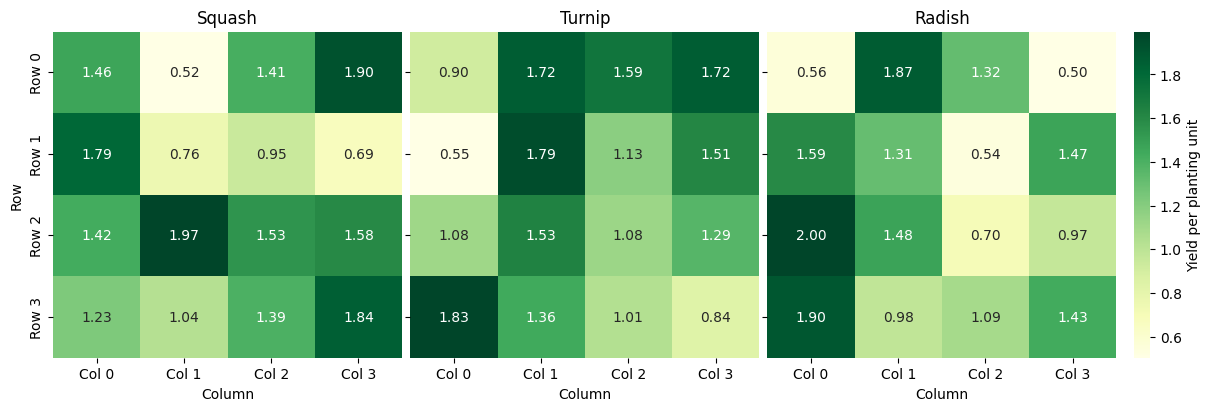

In [112]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, constrained_layout=True)
for c_idx, c_name in enumerate(crops):
    grid = y[:, c_idx].reshape(4, 4)

    ax = axes[c_idx]
    sns.heatmap(
        grid,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap="YlGn",
        cbar=(c_idx == 2),
        cbar_kws={"label": "Yield per planting unit"},
        xticklabels=[f"Col {j}" for j in range(4)],
        yticklabels=[f"Row {i}" for i in range(4)],
    )
    ax.set_title(f"{c_name}")
    ax.set_xlabel("Column")
    if c_idx == 0:
        ax.set_ylabel("Row")
    else:
        ax.set_ylabel("")

plt.show()

In [113]:
# Decision Variable
x = cp.Variable((num_patches, num_crops), integer=True)
constraints = []

### 2.2 Patch Capacity
We assume each patch can host at most $K$ planting units in total (across all crops), for example $K = 4$:
$$
\underline{K} \leq \sum_{c \in \mathcal{C}} x_{p c} \le \bar{K},
\quad \forall p \in \mathcal{P}.
$$

In [114]:
for p in patch_indices:
    constraints.append(cp.sum(x[p, :]) <= K[1])
    constraints.append(cp.sum(x[p, :]) >= K[0])

### 2.3 Sizing Constraint
To control the overall planted area of each vegetable across the entire field, we impose lower and upper bounds on the total number of planting units per crop. Let $L_c$ and $U_c$ be the minimum and maximum total planting units allowed for crop $c$ on the whole farm. Then, for each $c \in \mathcal{C}$,
$$
L_c \;\le\; \sum_{p \in \mathcal{P}} x_{p c} \;\le\; U_c.
$$

In [115]:
for c in crop_indices:
    total_units_c = cp.sum(x[:, c])
    constraints.append(total_units_c >= L[c])
    constraints.append(total_units_c <= U[c])

### 2.3 Objective function
The expected profit from allocating $x_{p c}$ planting units of crop $c$ to patch $p$ is
$$
(\pi_c - \gamma_c) \, y_{p c} \, x_{p c},
$$
so the total expected profit over the whole field is
$$
\sum_{p \in \mathcal{P}} \sum_{c \in \mathcal{C}} (\pi_c - \gamma_c) \, y_{p c} \, x_{p c}.
$$
We want to maximize this quantity:
$$
\max_{x} \; \sum_{p \in \mathcal{P}} \sum_{c \in \mathcal{C}} (\pi_c - \gamma_c) \, y_{p c} \, x_{p c}.
$$


In [116]:
patch_crop_profit = y * (price - cost)  # expected profit per planting unit

objective = cp.Maximize(cp.sum(cp.multiply(patch_crop_profit, x)))

# Define the problem
problem = cp.Problem(objective, constraints)

In [117]:
solution_value = problem.solve(solver=cp.GLPK_MI)

print("Problem status:", problem.status)
print(f"Optimal objective (total expected profit): $ {solution_value:.2f}")

x_sol = np.array(x.value)

Problem status: optimal
Optimal objective (total expected profit): $ 225.85


In [124]:
def plot_crop_grid(x_sol, patches, crops, cmap="Greens_r", figsize=(4, 4)):

    x_sol = np.asarray(x_sol)
    x_int = np.rint(x_sol).astype(int)

    num_patches, num_crops = x_int.shape
    # Infer grid size from max row/col in patches
    rows = max(r for r, _ in patches) + 1
    cols = max(c for _, c in patches) + 1

    # Dominant crop and units per patch
    max_crop_idx = np.argmax(x_int, axis=1)      # (num_patches,)
    max_units    = np.max(x_int, axis=1)         # (num_patches,)

    labels_grid = np.empty((rows, cols), dtype=object)
    units_grid  = np.zeros((rows, cols), dtype=float)

    for p_idx, (row, col) in enumerate(patches):
        c_idx = max_crop_idx[p_idx]
        units = max_units[p_idx]
        crop_name = crops[c_idx] if units > 0 else "None"
        labels_grid[row, col] = f"{crop_name}\n({units})"
        units_grid[row, col] = units

    fig, ax = plt.subplots(figsize=figsize)

    vmax = np.max(units_grid) if np.max(units_grid) > 0 else 1
    im = ax.imshow(units_grid, cmap=cmap, vmin=0, vmax=vmax)

    for i in range(rows):
        for j in range(cols):
            ax.text(j, i, labels_grid[i, j],
                    ha="center", va="center", color="black")

    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xticklabels([f"Col {j}" for j in range(cols)])
    ax.set_yticklabels([f"Row {i}" for i in range(rows)])

    plt.tight_layout()
    plt.show()

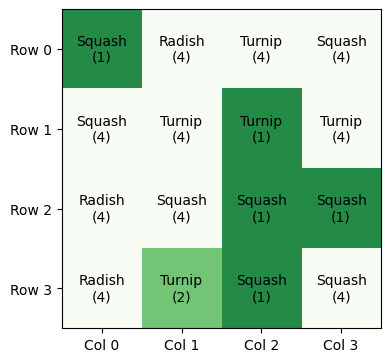

In [125]:
plot_crop_grid(x_sol, patches, crops, cmap="Greens_r",
               figsize=(4, 4))

*Note:* Both ILP and MILP problems are generally NP-hard, because the integrality requirements destroy convexity and lead to a discrete feasible set. Modern solvers tackle both ILP and MILP using similar algorithmic ideas, such as branch-and-bound, cutting planes, and branch-and-cut. However, the presence of continuous variables in MILP can sometimes help tighten relaxations and provide stronger bounds, while at the same time introducing additional coupling that may increase the search effort. In summary, ILP can be viewed as a special, purely discrete corner of the broader MILP framework.

## Activity: Extending the Vegetable Crop

Change the field from a $4 \times 4$ grid to a $5 \times 5$ grid.  
Let
$$
\mathcal{P} = \{(i,j) \mid i = 0,\dots,4,\; j = 0,\dots,4\}
$$
be the set of patches (indexed by row $i$ and column $j$).  
Extend the set of crops to include a new vegetable, Carrot:
$$
\mathcal{C} = \{\text{Squash}, \text{Turnip}, \text{Radish}, \text{Carrot}\}.
$$
For each crop $c \in \mathcal{C}$, you are given a selling price per unit yield $p_c$ and a cost per planting unit $k_c$. Use the same parameters as before for Squash, Turnip, and Radish, and add Carrot with
$$
\gamma_{\text{Carrot}} = 0.12, \qquad \pi_{\text{Carrot}} = 2.5.
$$
For each patch $p \in \mathcal{P}$ and crop $c \in \mathcal{C}$, you are again given an expected yield per planting unit $y_{pc}$ (which can be randomly generated).


Modify the model to satisfy the following additional constraints:

  * *No squashes in the first row.*  
  For all patches in the first row ($i = 0$) and for crop Squash:
  $$
  x_{(0,j),\text{Squash}} = 0, \qquad j = 0,\dots,4.
  $$

  * *No radishes in the last row.*
  For all patches in the last row ($i = 4$) and for crop Radish:
  $$
  x_{(4,j),\text{Radish}} = 0, \qquad j = 0,\dots,4.
  $$

  * *Only carrots in the rightmost plot.*
  Consider the rightmost plot in the grid (for example, the patch $(4,4)$).  
  On this patch, all crops except Carrot must have zero planting units:
  $$
  x_{(4,4),c} = 0 \quad \text{for all } c \in \mathcal{C} \setminus \{\text{Carrot}\}.
  $$
  (If you interpret “rightmost plot” as the entire rightmost column instead of a single patch, then enforce $x_{(i,4),c} = 0$ for all $i$ and all $c \neq \text{Carrot}$.)




Update the parameter definitions and decision variables to handle the $5 \times 5$ grid and the new crop Carrot.
Implement the new planting restrictions in your CVXPY model.
Solve the modified MILP and report:

1. The optimal planting units $x_{pc}$ for each patch and crop.
2. The total cost, revenue, and net profit.
3. A $5 \times 5$ grid visualization showing, for each patch, the dominant crop and the number of planting units.


In [ ]:
### CODE REVISION

## Parameters
patches = [(i, j) for i in range(4) for j in range(4)]
num_patches = len(patches)

crops = ["Squash", "Turnip", "Radish"]
num_crops = len(crops)

patch_indices = range(num_patches)
crop_indices = range(num_crops)

# Profit per unit yield for each crop
cost = np.array([0.7, 0.12, 0.26])
price = np.array([4.0, 2.0, 3.0])


rng = np.random.default_rng(seed=0)
y = rng.uniform(low=0.5, high=2.0, size=(num_patches, num_crops))

K = (1,4)

L = np.array([5, 3, 2])
U = np.array([20, 15, 12])

## Decision Variable
x = cp.Variable((num_patches, num_crops), integer=True)
constraints = []

## Constraints
for p in patch_indices:
    constraints.append(cp.sum(x[p, :]) <= K[1])
    constraints.append(cp.sum(x[p, :]) >= K[0])

for c in crop_indices:
    total_units_c = cp.sum(x[:, c])
    constraints.append(total_units_c >= L[c])
    constraints.append(total_units_c <= U[c])

patch_crop_profit = y * (price - cost)  # expected profit per planting unit

objective = cp.Maximize(cp.sum(cp.multiply(patch_crop_profit, x)))

# Define the problem
problem = cp.Problem(objective, constraints)


solution_value = problem.solve(solver=cp.GLPK_MI)

print("Problem status:", problem.status)
print(f"Optimal objective (total expected profit): $ {solution_value:.2f}")

x_sol = np.array(x.value)